In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from visual_genome import api
from PIL import Image as PIL_Image
import requests
from io import StringIO, BytesIO
import sys
import json
from pathlib import Path


In [2]:

res_file_path = '/home/ta/Projects/SUTD/VSRL/data/VisualGenome/semantic_relationsips_final_full.json'
object_file_path = '/home/ta/Projects/SUTD/VSRL/data/VisualGenome/objects.json'
region_file_path = '/home/ta/Projects/SUTD/VSRL/data/VisualGenome/Archive/region_descriptions_updated_final.json'

res_data = json.load(open(res_file_path))
object_data = json.load(open(object_file_path))
region_data = json.load(open(region_file_path))


In [3]:
mapping_id = {
    'region': {},
    'object': {}
}

for id_, region in enumerate(region_data):
    mapping_id['region'][region['id']] = id_

for id_, object in enumerate(object_data):
    mapping_id['object'][object['image_id']] = id_


In [4]:
from collections import namedtuple

Rec = namedtuple('Rec', 'xmin ymin xmax ymax')

def intersect(a, b):  # returns None if rectangles don't intersect
    dx = min(a.xmax, b.xmax) - max(a.xmin, b.xmin)
    dy = min(a.ymax, b.ymax) - max(a.ymin, b.ymin)
    if (dx>=0) and (dy>=0):
        return dx*dy
    else:
        return 0.0

def get_verlap_ratio(region1,region2,obj):
    obj_region_intsct = intersect(region1, region2)
#     print('overlapping area : ', obj_region_intsct)

    if obj_region_intsct == 0.0:
        return 0.0

    object_overlap_ratio = obj_region_intsct / float(obj['w']*obj['h'])
#     print('overlap ratio:', object_overlap_ratio)
    return object_overlap_ratio


In [5]:

filtered_file_path = '/home/ta/Projects/SUTD/VSRL/code/filetoverify/semantic_relationsips_filtered2432018.json'
filtered_data = json.load(open(filtered_file_path)) 

All objects in this image
couch
dog
ear
eye
glasses
hair
nose
pants
paws
sweater
tail
wall
woman
{'region_id': 1084320, 'height': 308, 'x': 221, 'y': 55, 'phrase': 'a woman relaxing on the couch', 'image_id': 2393164, 'width': 242, 'parsed phrase': {'hasVerb': True, 'verbs': {'relax.01': {'A1': {'a woman': 'DT NN'}, 'AM-LOC': {'on the couch': 'IN DT NN'}}}}}
image_id = 2393164
region_choice=
{'region_id': 1084320,
 'region_relations': {'place': 1222346,
                      'predicate': 'relax',
                      'thing relaxing': 1222342}}
values = [1222342, 1222346]
parsed_phrase = {'hasVerb': True, 'verbs': {'relax.01': {'A1': {'a woman': 'DT NN'}, 'AM-LOC': {'on the couch': 'IN DT NN'}}}}
phrase= a woman relaxing on the couch
1222346 couch
1222342 woman


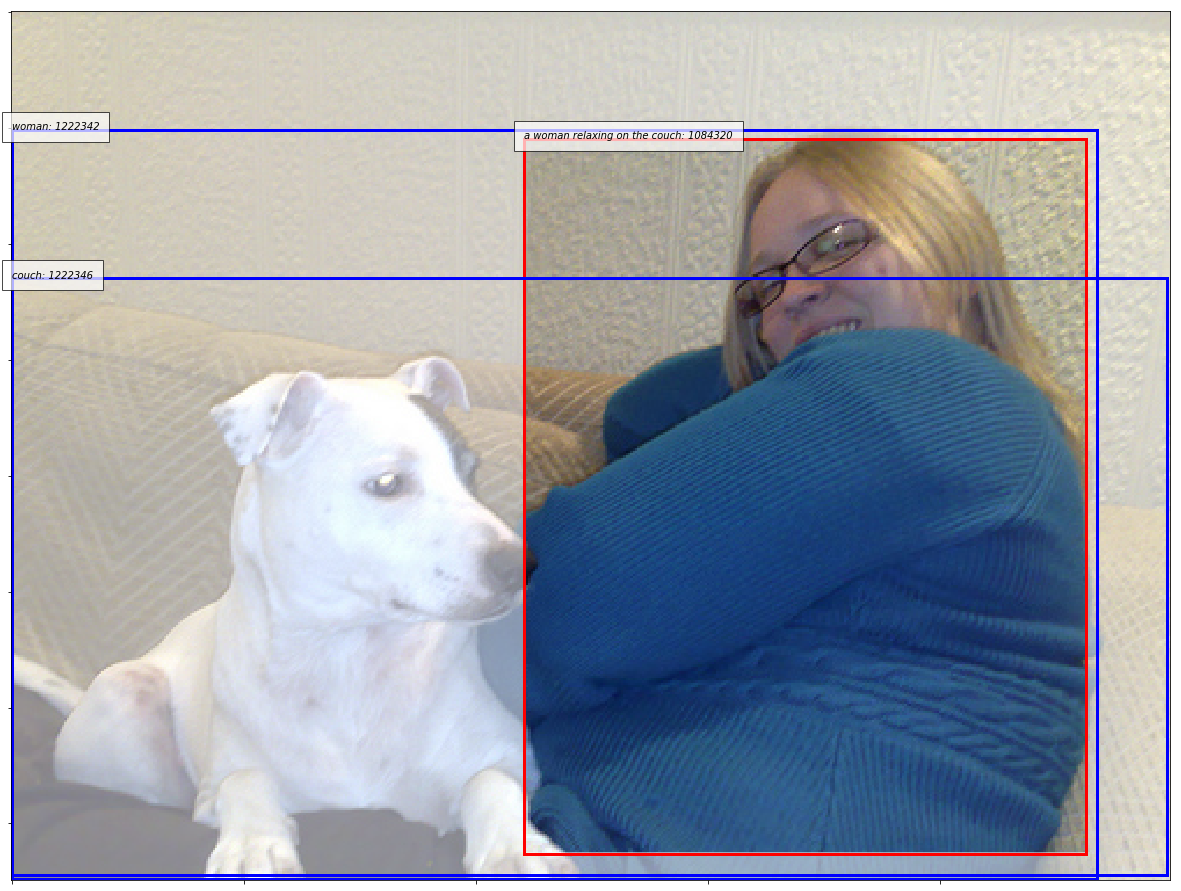

In [10]:
def visualize_ids(image_id, region_ids=None, object_ids=None, new_region=None):
    raw_image = api.get_image_data(id=image_id) 
    objects = object_data[mapping_id['object'][image_id]]['objects']
    regions = region_data[mapping_id['region'][image_id]]['regions']

    selected_regions = [x for x in regions if x['region_id'] in region_ids]
    selected_objects = [x for x in objects if x['object_id'] in object_ids] # or x['names'][0] == 'man']

    for region in selected_regions:
        print ('phrase=', region['phrase']) 
    for object in selected_objects:
        print (object['object_id'], object['names'][0]) 
    
    visualize_regions_objects(raw_image, selected_regions, selected_objects, None) 

import random

image_choice = random.choice(filtered_data)
import pprint

region_choice = random.choice(image_choice['relationships']) 

values = [x[1] for x in region_choice['region_relations'].items() if x[0] != 'predicate']

image_id = image_choice['image_id'] 
region_id = region_choice['region_id']
#list all obj in this image 
objects = object_data[mapping_id['object'][image_id]]['objects'] 
print('All objects in this image') 
for obj in objects:
    print (obj['names'][0]) 

#list parsed phrase 
regions = region_data[mapping_id['region'][image_id]]['regions']
parsed_region = [x for x in regions if x['region_id'] == region_id][0]
print (parsed_region)
parsed_phrase = parsed_region['parsed phrase']

print ('image_id =', image_choice['image_id'])  
print ('region_choice=')
pprint.pprint(region_choice)  
print ('values =', values)  
print ('parsed_phrase =', parsed_phrase)
visualize_ids(image_id, [region_choice['region_id']], values, None)

In [8]:
def normalize(img, new_region):
    crop_img = img.crop((new_region.xmin, new_region.ymin,
                   new_region.xmax,
                   new_region.ymax))
    crop_img.putalpha(255)
    img.paste(crop_img, (new_region.xmin, new_region.ymin))
    return img

def visualize_regions_objects(image, regions, objects, new_region=None):
    fig = plt.gcf()
    fig.set_size_inches(30, 16, forward=True)
    response = requests.get(image.url)
    img = PIL_Image.open(BytesIO(response.content))
    
    ax = plt.gca()
    img.putalpha(128) 

    if regions != None:
        for region in regions:
            ax.add_patch(Rectangle((region['x'], region['y']),
                                   region['width'],
                                   region['height'],
                                   fill=False,
                                   edgecolor='red',
                                   linewidth=3))
            ax.text(region['x'],
                    region['y'],
                    region['phrase'] + ': ' + str(region['region_id']),
                    style='italic',
                    bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})
            img = normalize(img, Rec(region['x'], 
                                     region['y'], 
                                     region['x'] + region['width'],
                                     region['y'] + region['height']))  

    if objects != None:
        for object_ in objects:
            ax.add_patch(Rectangle((object_['x'], object_['y']),
                                   object_['w'],
                                   object_['h'],
                                   fill=False,
                                   edgecolor='blue',
                                   linewidth=3))

            ax.text(object_['x'],
                    object_['y'],
                    object_['names'][0] + ': ' + str(object_['object_id']),
                    style='italic',
                    bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})
            
    if new_region != None:
        ax.add_patch(Rectangle((new_region.xmin, new_region.ymin),
                               new_region.xmax - new_region.xmin,
                               new_region.ymax - new_region.ymin,
                                fill=False,
                               edgecolor='black',
                                   linewidth=5))
    
        ax.text(new_region.xmin,
                new_region.ymin,
                "new_bbox",
                style='italic',
                bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})
        
        img = normalize(img, new_region)  
        
#         plt.savefig('res/' + str(image.id))
#         save_path = Path('res/bboxfor/' + str(image.id))
#         save_path.mkdir(exist_ok=True) 
#         image_path = save_path / (str(regions[0]['region_id'])+ '.jpg')
#         print (image_path)
#         plt.savefig(image_path) 
        
#         crop_img.show() 
#         save crop_img
#         crop_img.save(image_path)

    fig = plt.gcf()
    plt.tick_params(labelbottom='off', labelleft='off') 
    plt.imshow(img) 
    
    #annotation tools: transparent 
#     img.paste(crop_img, (new_region.xmin, new_region.ymin))

#     if objects == None or len(objects) == 0:
# #         plt.savefig('res/bbox_region/' + str(regions[0]['region_id']))
#         pass 
#     else:
#         print('Detect objects!')
#         print(objects)
#         plt.savefig('res/bbox_region_only/' + str(regions[0]['region_id']))
#         plt.set_alpha(0.7)
    plt.show()
    plt.clf()
    

In [5]:
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

def draw_rectangle(draw, coordinates, color, width=1):
    for i in range(width):
        rect_start = (coordinates[0][0] - i, coordinates[0][1] - i)
        rect_end = (coordinates[1][0] + i, coordinates[1][1] + i)
        draw.rectangle((rect_start, rect_end), outline = color)

def visualize_annotation(image, region_id, new_region): 
    plt.clf()
    fig = plt.gcf()
    fig.set_size_inches(30, 16, forward=True)
    response = requests.get(image.url)
    img = PIL_Image.open(BytesIO(response.content))
    
    ax = plt.gca()
    img.putalpha(128) 
    
#     ax.add_patch(Rectangle((new_region.xmin, new_region.ymin),
#                                new_region.xmax - new_region.xmin,
#                                new_region.ymax - new_region.ymin,
#                                 fill=False,
#                                edgecolor='black',
#                                linewidth=5))
    
    crop_img = img.crop((new_region.xmin, new_region.ymin,
               new_region.xmax,
               new_region.ymax))
    
    crop_img.putalpha(255)
    img.paste(crop_img, (new_region.xmin, new_region.ymin))
    draw = ImageDraw.Draw(img)
    draw_rectangle(draw, ((new_region.xmin, new_region.ymin),
                    (new_region.xmax, 
                    new_region.ymax)), "black", 5)
#     img.show() 
    
    save_path = Path('res/bboxfor/' + str(image.id))
    save_path.mkdir(exist_ok=True) 
    image_path = save_path / (str(region_id) + '.png')
    print (image_path)
    
    fig = plt.gcf()
    plt.tick_params(labelbottom='off', labelleft='off')
    
    plt.imshow(img) 
#     print (img.shape)
#     plt.show()
    print (plt, type(plt))
    img.save(image_path, 'PNG') 
                   
#     plt.savefig(image_path, transparent=True, format='png') 
    
#     plt.show()
    
    

In [26]:
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
from PIL import Image as PIL_Image

def draw_rectangle(draw, coordinates, color, width=1):
    for i in range(width):
        rect_start = (coordinates[0][0] - i, coordinates[0][1] - i)
        rect_end = (coordinates[1][0] + i, coordinates[1][1] + i)
        draw.rectangle((rect_start, rect_end), outline = color)

        
def draw_bbox_object(image, coor):
    draw = ImageDraw.Draw(image)
    draw_rectangle(draw, ((coor[0], coor[1]),
                    (coor[2], coor[3])), "yellow", 3)
    return image 
    
img = PIL_Image.open('data/1382.png', 'r') 
new_img = draw_bbox_object(img, (238, 254, 238 + 57, 254 + 259))
new_img.show() 

# "h": 259,
#                "merged_object_ids": [],
#                "names": ["man"],
#                "object_id": 3798577,
#                "synsets": ["man.n.01"],
#                "w": 57,
#                "x": 238,
#                "y": 254}

In [8]:
    import math 
    from pprint import pprint

for image in res_data:
    image_id = image['image_id']
    
    if image_id > 2: 
        break 
        
    print ('Current processing at image', image_id)
    objects = object_data[mapping_id['object'][image_id]]['objects']

    # regions = api.get_region_descriptions_of_image(id=image_id)
    regions = region_data[mapping_id['region'][image_id]]['regions']
    raw_image = api.get_image_data(id=image_id)

    for region in image['relationships']:
        objects_region = []
        for k, v in region['region_relations'].items():
            if isinstance(v,int):
                objects_region.append(v)
            else:
                numbers = [int(e) for e in v.split() if e.isdigit()]
                objects_region.extend(numbers)
        
#         pprint (region['region_relations']) 

        selected_regions = [x for x in regions if x['region_id'] == region['region_id']]
        selected_objects = [x for x in objects if x['object_id'] in objects_region]
        
        print (selected_regions[0]['phrase'])
        
#         print (selected_objects) 
#         print (selected_regions)
#         error_image = True 
        
        region_bb = selected_regions[0] 
        region_box = Rec(region_bb['x'], 
                         region_bb['y'], 
                         region_bb['x'] + region_bb['width'], 
                         region_bb['y'] + region_bb['height'])
        
        xmin = region_bb['x']
        ymin = region_bb['y']
        xmax = region_bb['x'] + region_bb['width']
        ymax = region_bb['y'] + region_bb['height']
        
        for obj in selected_objects: 
            print ('Current object:', obj['names'][0])
            xmin = min(obj['x'], xmin) 
            ymin = min(obj['y'], ymin) 
            xmax = max(obj['x'] + obj['w'], xmax) 
            ymax = max(obj['y'] + obj['h'], ymax) 
            
            obj_box = Rec(obj['x'], 
                          obj['y'], 
                          obj['x'] + obj['w'], 
                          obj['y'] + obj['h'])
    
#         if error_image:
        
        new_region_box = Rec(xmin - 2, ymin - 2, xmax + 2, ymax + 2) 
#         print ('New region =', new_region_box)
#         visualize_annotation(raw_image, region['region_id'], new_region_box)

#         else:
#             new_region_box = None
#             print ('None') 
            
        visualize_regions_objects(raw_image, selected_regions, selected_objects, new_region_box)
#         if 
    
        
        break 
    break 
    print ('')

print ('Done!!') 

Current processing at image 1
man has raised his arm
Current object: man
Current object: arm
res/bboxfor/1/1736.jpg


TypeError: Object does not appear to be a 8-bit string path or a Python file-like object

ValueError: Image size of 622914x247921 pixels is too large. It must be less than 2^16 in each direction.